In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [10]:
module = fc.eightb.preselection.ranked_quadh
signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1200_MY_500)])
bkg = ObjIter([Tree(module.Bkg_MC_List, use_gen=False)])

100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


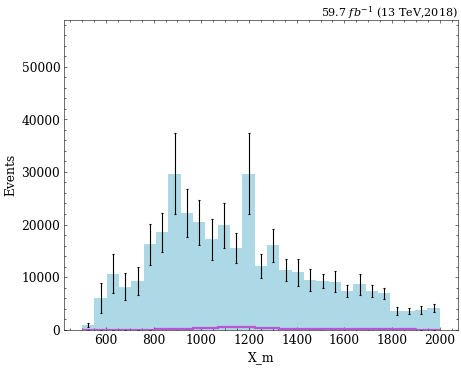

In [11]:
histos = obj_store()
study.quick(
    signal+bkg,
    masks=lambda t : t.n_loose_btag >= 6,
    varlist=['X_m'],
    store=histos,
)

In [12]:
h_bkg, h_sig = histos[0]
h_bkg = h_bkg.get_histo()

In [13]:
h_data = copy.deepcopy(h_bkg)
h_data.histo = h_bkg.histo*np.random.normal(loc=1, scale=0.09, size=len(h_bkg.histo))
h_data.is_data = True
h_data.is_bkg = False
h_data.kwargs.update(color='black', marker='o', linestyle='None', label='Data')

In [14]:
model = Model(h_sig, h_bkg, h_data)
model.upperlimit()

(DeviceArray(4.34441652, dtype=float64),
 [DeviceArray(2.78728748, dtype=float64),
  DeviceArray(3.6947292, dtype=float64),
  DeviceArray(5.07172545, dtype=float64),
  DeviceArray(6.89136173, dtype=float64),
  DeviceArray(8.985507, dtype=float64)])

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

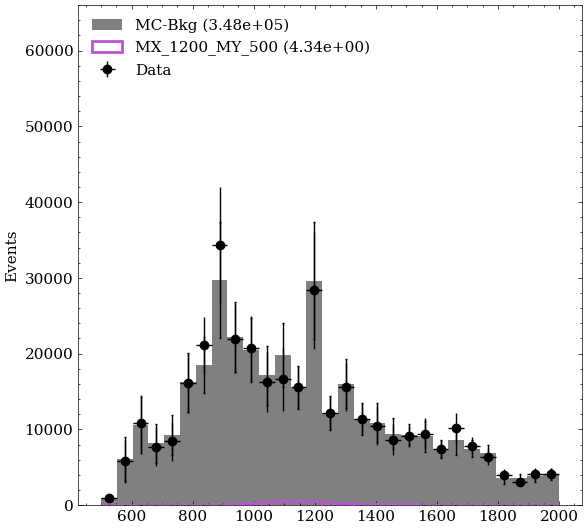

In [15]:
h_sig.set_label('obs_limit')
graph_histos([h_data])
plot_histos([h_bkg, h_sig], figax='same', legend=True)

In [24]:
model.export_to_root(saveas='pyhf_test.root')

Welcome to JupyROOT 6.24/06
Norm: 0.6913165092452556


In [25]:
!readlink -f pyhf_test.root

/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/tutorials/pyhf_test.root


In [26]:
!cat /uscms_data/d3/ekoenig/8BAnalysis/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/8b/test/datacard.txt

# X -> YY -> 4H -> 8b
# with one signal and a few background processes
imax * number of channels
jmax * number of backgrounds
kmax * number of nuisance parameters (sources of systematical uncertainties)

shapes * * input/$FILE.root $PROCESS
----
bin bin1
observation -1
bin           bin1      bin1  
process		    nmssm     bkg  
process		     0         1    
rate		     -1         -1
----
* autoMCStats 0

In [30]:
!tail /uscms_data/d3/ekoenig/8BAnalysis/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/8b/test/combine_pyhf.out


 -- AsymptoticLimits ( CLs ) --
Observed Limit: r < 0.6128
Expected  2.5%: r < 0.2747
Expected 16.0%: r < 0.3650
Expected 50.0%: r < 0.5059
Expected 84.0%: r < 0.7035
Expected 97.5%: r < 0.9350

Done in 0.00 min (cpu), 0.00 min (real)


In [33]:
print(
    "From PyHF\n"
    f"Observed Limit: r < {h_sig.stats.obs_limit:0.4f}"
)
for explim, quantile in zip(h_sig.stats.exp_limits,[0.025,0.16,0.50,0.84,0.975]):
    print(f"Expected {quantile:0.2%}: r < {explim:0.4}")

From pyhf
Observed Limit: r < 0.5243
Expected 2.50%: r < 0.2702
Expected 16.00%: r < 0.3611
Expected 50.00%: r < 0.4962
Expected 84.00%: r < 0.6836
Expected 97.50%: r < 0.9074
